In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
from math import exp
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
ipsc_core = load_json_model('../data/gems/iPSC_core.json')

# fix reaction directions

In [3]:
for rxn_id in ['G6PDH2r','PGI','FBA','GAPD','PGK','PGM','ENO','LDH_L','ACONT','ACONTm','SUCOAS1m',
              'SUCD1m','FUMm','MDHm','ASPTAm','GLUDym','GDHm','ACOAH','ORNTArm','ICDHym']:
    ipsc_core.reactions.get_by_id(rxn_id).lower_bound=0.0

In [4]:
Adata = pd.read_csv('../data/gems/EnzymeActivity.csv')
A_dict = {Adata['Rxn'][i]:Adata['Activity(mmol/hr/g)'][i] for i in range(len(Adata.index))}

In [5]:
print(ipsc_core.medium.keys())

dict_keys(['EX_glc__D_e', 'EX_h_e', 'EX_pi_e', 'EX_o2_e', 'EX_h2o_e', 'EX_chol_e', 'EX_hco3_e', 'EX_na1_e', 'EX_hxan_e', 'EX_so4_e', 'EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 'EX_trp__L_e', 'EX_asp__L_e', 'EX_k_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e'])


In [6]:
# for rxn_id in ex_aa_list:
#     ipsc_core.reactions.get_by_id(rxn_id).upper_bound=0.0

In [9]:
ex_aa_list = ['EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 
              'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 
              'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 
              'EX_trp__L_e', 'EX_asp__L_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e']
def set_PA(model, ptot, A_dict):
    sigma=0.5
    t_sector = model.reactions.EX_lac__L_e.flux_expression/(sigma*A_dict['EX_lac__L_e']) +\
           (-1)*model.reactions.EX_glc__D_e.flux_expression/A_dict['EX_glc__D_e'] +\
             model.reactions.EX_ac_e.flux_expression/(sigma*A_dict['EX_ac_e'])
    for ex_aa in ex_aa_list:
        t_sector = t_sector + (-1)*model.reactions.get_by_id(ex_aa).flux_expression/A_dict['EX_aa_e']
    a_sector = model.reactions.BIOMASS.flux_expression/A_dict['BIOMASS']
    ngam_sector = model.reactions.ATPM.flux_expression/A_dict['ATPM']
    c_sector = model.reactions.ENO.flux_expression/(sigma*A_dict['ENO'])
    for k in A_dict.keys():
        if k not in ['ENO','EX_lac__L_e', 'EX_ac_e','EX_glc__D_e','EX_aa_e','ATPM','BIOMASS']:
            c_sector  = c_sector  + model.reactions.get_by_id(k).flux_expression/(sigma*A_dict[k])
    PA = model.problem.Constraint( expression = a_sector + c_sector + ngam_sector,
                        name = 'PA', lb= 0, ub = ptot)
    model.add_cons_vars([ PA ])
    return None

def get_NGAM( NGAM_0, r_max, nh4_con, lac_con, k1, k2, z1, z2):
    r = 1+(r_max-1)*(1+exp(-k1*(nh4_con-z1) ))**-1*(1+exp(-k2*(lac_con-z2) ))**-1
    return r* NGAM_0

In [11]:
ptot = 0.56; NGAM_0 = 5.9; #https://doi.org/10.1371/journal.pcbi.1009022
with ipsc_core:
#     rxn_string ='0.449091248 ala__L_c + 0.24692711 arg__L_c + 0.208891647 asn__L_c + 0.257573151 asp__L_c + 87.9 atp_c \
#             + 0.086970857 chsterol_c + 0.097355132 ctp_c + 0.083083581 cys__L_c + 0.035778189 datp_c + 0.025172729 dctp_c \
#             + 0.025172729 dgtp_c + 0.035778189 dttp_c + 0.353206758 gln__L_c + 0.303246063 glu__L_c + 0.476689682 gly_c + \
#             0.102935005 gtp_c + 24.74849172 h2o_c + 0.096216462 his__L_c + 0.220171565 ile__L_c + 0.427292446 leu__L_c \
#             + 0.387642487 lys__L_c + 0.105583014 met__L_c + 0.018176901 pail_psc_c + 0.130185913 pchol_psc_c +\
#             0.049863661 pe_psc_c + 0.001473803 pglyc_psc_c + 0.186720668 phe__L_c + 0.222059892 pro__L_c + 0.016457464 ps_psc_c \
#             + 0.32299952 ser__L_c + 0.02137014 sphmyln_psc_c + 0.255370881 thr__L_c + 0.025172972 trp__L_c \
#             + 0.131253338 tyr__L_c + 0.085375963 utp_c + 0.32262571 val__L_c \
#             --> 87.8 adp_c + 87.8 h_c + 87.8 pi_c + 0.512102766 ppi_c'
#     ipsc_core.reactions.BIOMASS.build_reaction_from_string(rxn_string)
    ex_aa_list = ['EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 
              'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 
              'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 
              'EX_trp__L_e', 'EX_asp__L_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e']
    ipsc_core.reactions.EX_glc__D_e.lower_bound=-1.82
#     for rxn_id in ex_aa_list:
#         ipsc_core.reactions.get_by_id(rxn_id).lower_bound=-0.66
    ipsc_core.reactions.ATPM.lower_bound = NGAM_0
    # Proteome constraints
    set_PA(ipsc_core, ptot, A_dict)
    fluxes = cobra.flux_analysis.pfba(ipsc_core).fluxes
    uptake_flux = ipsc_core.summary().uptake_flux
    secretion_flux = ipsc_core.summary().secretion_flux
    print(ipsc_core.summary())

Objective
1.0 BIOMASS = 0.07704320649365777

Uptake
------
Metabolite    Reaction     Flux  C-Number C-Flux
  ala__L_e EX_ala__L_e   0.0346         3  0.57%
  arg__L_e EX_arg__L_e  0.01902         6  0.63%
  asn__L_e EX_asn__L_e  0.06552         4  1.45%
    chol_e   EX_chol_e  0.01168         5  0.32%
  cys__L_e EX_cys__L_e 0.006401         3  0.11%
  glc__D_e EX_glc__D_e     1.82         6 60.49%
  gln__L_e EX_gln__L_e  0.03977         5  1.10%
     gly_e    EX_gly_e 0.006922         2  0.08%
    hco3_e   EX_hco3_e  0.01877         1  0.10%
  his__L_e EX_his__L_e 0.007413         6  0.25%
    hxan_e   EX_hxan_e  0.02068         5  0.57%
  ile__L_e EX_ile__L_e  0.01696         6  0.56%
  leu__L_e EX_leu__L_e  0.03292         6  1.09%
  lys__L_e EX_lys__L_e  0.02987         6  0.99%
  met__L_e EX_met__L_e 0.008134         5  0.23%
      o2_e     EX_o2_e    1.121         0  0.00%
  phe__L_e EX_phe__L_e  0.01439         9  0.72%
      pi_e     EX_pi_e   0.6879         0  0.00%
  pro__L_e

In [12]:
# fluxes.to_csv('../data/gems/fluxes_ipsc.csv')

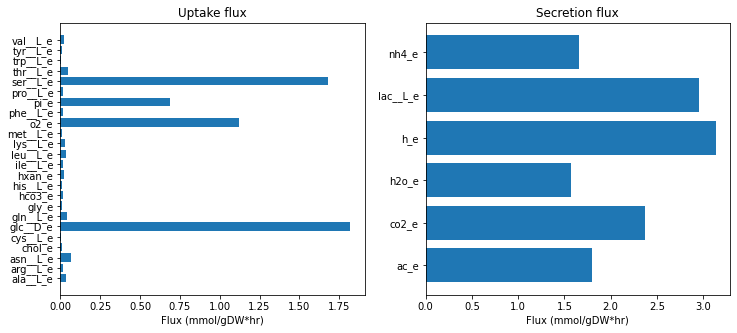

In [18]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
secretion_flux = secretion_flux[secretion_flux.flux!=0]
uptake_flux = uptake_flux[uptake_flux.flux!=0]
axs[0].barh(uptake_flux.metabolite,uptake_flux.flux)
axs[1].barh(secretion_flux.metabolite,-1*secretion_flux.flux)
axs[0].set_title('Uptake flux')
axs[1].set_title('Secretion flux')
for ax in axs:
    ax.set_xlabel('Flux (mmol/gDW*hr)')

In [18]:
secretion_flux

,flux,reaction,metabolite
EX_ac_e,-1.330848,EX_ac_e,ac_e
EX_asp__L_e,0.000000,EX_asp__L_e,asp__L_e
EX_co2_e,-2.219291,EX_co2_e,co2_e
EX_glu__L_e,0.000000,EX_glu__L_e,glu__L_e
EX_h2o_e,-1.786766,EX_h2o_e,h2o_e
EX_h_e,-2.812856,EX_h_e,h_e
EX_k_e,0.000000,EX_k_e,k_e
EX_lac__L_e,-2.737421,EX_lac__L_e,lac__L_e
EX_na1_e,0.000000,EX_na1_e,na1_e
EX_nh4_e,-1.292021,EX_nh4_e,nh4_e


In [10]:
def get_fluxes_NGAM(model,  ptot, A_dict, NGAM):
    with model:
        model.reactions.ATPM.lower_bound = NGAM
        # extra constraints
        model.reactions.EX_ac_e.upper_bound=0
        model.reactions.EX_succ_e.upper_bound=0
        model.reactions.EX_pyr_e.upper_bound=0
        # Proteome constraints
        set_PA(model, ptot, A_dict)
        fluxes = cobra.flux_analysis.pfba(model).fluxes
    return fluxes

In [11]:
NGAMs = np.linspace(4,10); ptot=0.5;
grs=[]; lac_fluxes=[]; nh4_fluxes=[];
for ngam in NGAMs:
    fluxes = get_fluxes_NGAM( ipsc_core,  ptot, A_dict, ngam)
    grs.append(fluxes['BIOMASS'])
    lac_fluxes.append(fluxes['EX_lac__L_e'])
    nh4_fluxes.append(fluxes['EX_nh4_e'])

Text(0, 0.5, 'NH4 secretion(mmol/gDW*hr)')

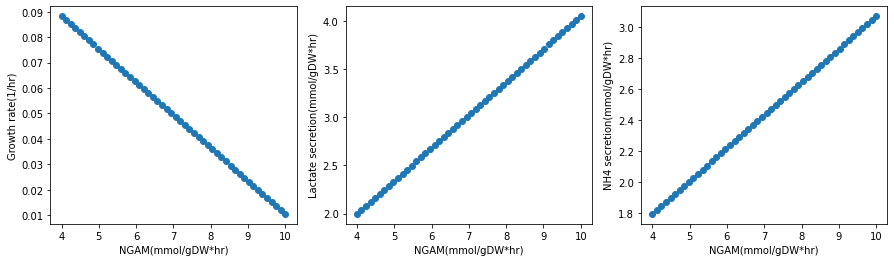

In [12]:
fig,axs=plt.subplots(1,3,figsize=(15,4))
axs[0].plot(NGAMs,grs,'o',ls='--')
axs[1].plot(NGAMs,lac_fluxes,'o',ls='--')
axs[2].plot(NGAMs,nh4_fluxes,'o',ls='--')
for ax in axs:
    ax.set_xlabel('NGAM(mmol/gDW*hr)')
axs[0].set_ylabel('Growth rate(1/hr)')
axs[1].set_ylabel('Lactate secretion(mmol/gDW*hr)')
axs[2].set_ylabel('NH4 secretion(mmol/gDW*hr)')